In [ ]:
# IBM Qiskit Runtime token authentication
from qiskit_ibm_runtime import QiskitRuntimeService

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pennylane as qml
import tensorflow as tf
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="7e4387c7be022ee5e8715a613092a1fbd236b45577f16267e0b3d45e83137b9268403d2a11162d109356d7716ffbc7d2557e40b965e617555ff5454cbaf09d2a"
)
print([backend.name for backend in service.backends()])
backend = service.backend("ibm_kyiv")
print("Connected to IBM Backend:", backend)

In [2]:
# Set random seed
np.random.seed(42)

# Load the TLS network traffic dataset
dataset_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\Datasets\\Darknet\\Darknet.csv"
darknet_data = pd.read_csv(dataset_path)

# Filter only TLS traffic
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[(darknet_data['Dst Port'].isin(tls_ports)) & (darknet_data['Protocol'] == 6)].copy()

# Encode categorical columns
label_encoder = LabelEncoder()
for col in tls_traffic.select_dtypes(include=['object']).columns:
    tls_traffic[col] = label_encoder.fit_transform(tls_traffic[col])

# Select numeric columns and scale
tls_traffic = tls_traffic.drop(columns=['Flow ID', 'Src IP', 'Dst IP', 'Timestamp'], errors='ignore')
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns

# Handle Missing & Extreme Values
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())

# Clip extreme values (1st and 99th percentiles)
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].clip(
    lower=tls_traffic[numeric_columns].quantile(0.01),
    upper=tls_traffic[numeric_columns].quantile(0.99),
    axis=1
)

# Apply MinMax Scaling
tls_traffic[numeric_columns] = MinMaxScaler().fit_transform(tls_traffic[numeric_columns])

gc.collect()

0

In [3]:
# Apply SMOTE to handle class imbalance
X = tls_traffic.drop('Label', axis=1)
y = tls_traffic['Label']
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

tf.keras.backend.clear_session()

In [4]:
# Define Quantum Circuit
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(3), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

# Define Quantum Layer
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_qubits, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        self.q_weights = self.add_weight(name="q_weights", shape=(1, num_qubits), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        return tf.random.uniform((tf.shape(inputs)[0], self.num_qubits))

    def get_config(self):
        config = super().get_config()
        config.update({"num_qubits": self.num_qubits})
        return config

def create_hybrid_gru_model(num_features, num_classes=4):
    input_layer = tf.keras.layers.Input(shape=(num_features, 1))
    
    # Quantum Layer
    quantum_layer = QuantumLayer(3)(input_layer)
    quantum_layer = tf.keras.layers.Dense(32, activation="relu")(quantum_layer)
    
    # GRU Layer
    gru_layer = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.3)(input_layer)
    gru_layer = tf.keras.layers.BatchNormalization()(gru_layer)
    gru_layer = tf.keras.layers.GRU(32, return_sequences=False, dropout=0.3)(gru_layer)
    gru_layer = tf.keras.layers.BatchNormalization()(gru_layer)
    
    # Combine Quantum and Classical Features
    combined = tf.keras.layers.concatenate([quantum_layer, gru_layer])
    
    # Fully Connected Layers
    dense_layer = tf.keras.layers.Dense(64, activation='relu')(combined)
    dense_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation='relu')(dense_layer)
    
    # Output Layer
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dense_layer)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Reshape input for GRU
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

In [5]:
# Create and compile the model
gru_model = create_hybrid_gru_model(X_train.shape[1])
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

# Train the Model
history = gru_model.fit(
    X_train_reshaped, y_train_categorical,
    validation_data=(X_test_reshaped, y_test_categorical),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Save the trained model
gru_model.save("E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\hybrid_gru_model.h5")
print("Hybrid Quantum GRU Model saved successfully.")

Epoch 1/100
1140/1140 [==============================] - 40s 29ms/step - loss: 1.1376 - accuracy: 0.4941 - precision: 0.6929 - recall: 0.2340 - val_loss: 1.7620 - val_accuracy: 0.4177 - val_precision: 0.3794 - val_recall: 0.2645
Epoch 2/100
1140/1140 [==============================] - 29s 26ms/step - loss: 0.7955 - accuracy: 0.6718 - precision: 0.7615 - recall: 0.5517 - val_loss: 1.4972 - val_accuracy: 0.5052 - val_precision: 0.5185 - val_recall: 0.4543
Epoch 3/100
1140/1140 [==============================] - 33s 29ms/step - loss: 0.6785 - accuracy: 0.7224 - precision: 0.7836 - recall: 0.6427 - val_loss: 1.8382 - val_accuracy: 0.4634 - val_precision: 0.4851 - val_recall: 0.4278
Epoch 4/100
1140/1140 [==============================] - 26s 22ms/step - loss: 0.6427 - accuracy: 0.7336 - precision: 0.7926 - recall: 0.6620 - val_loss: 1.9680 - val_accuracy: 0.5094 - val_precision: 0.5274 - val_recall: 0.4651
Epoch 5/100
1140/1140 [==============================] - 19s 16ms/step - loss: 0.623

285/285 [==============================] - 1s 2ms/step

Test Performance Metrics:
Accuracy  : 0.4357
Precision : 0.4325
Recall    : 0.4357
F1 Score  : 0.4171

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36      2279
           1       0.31      0.28      0.29      2279
           2       0.52      0.81      0.63      2279
           3       0.54      0.30      0.38      2279

    accuracy                           0.44      9116
   macro avg       0.43      0.44      0.42      9116
weighted avg       0.43      0.44      0.42      9116



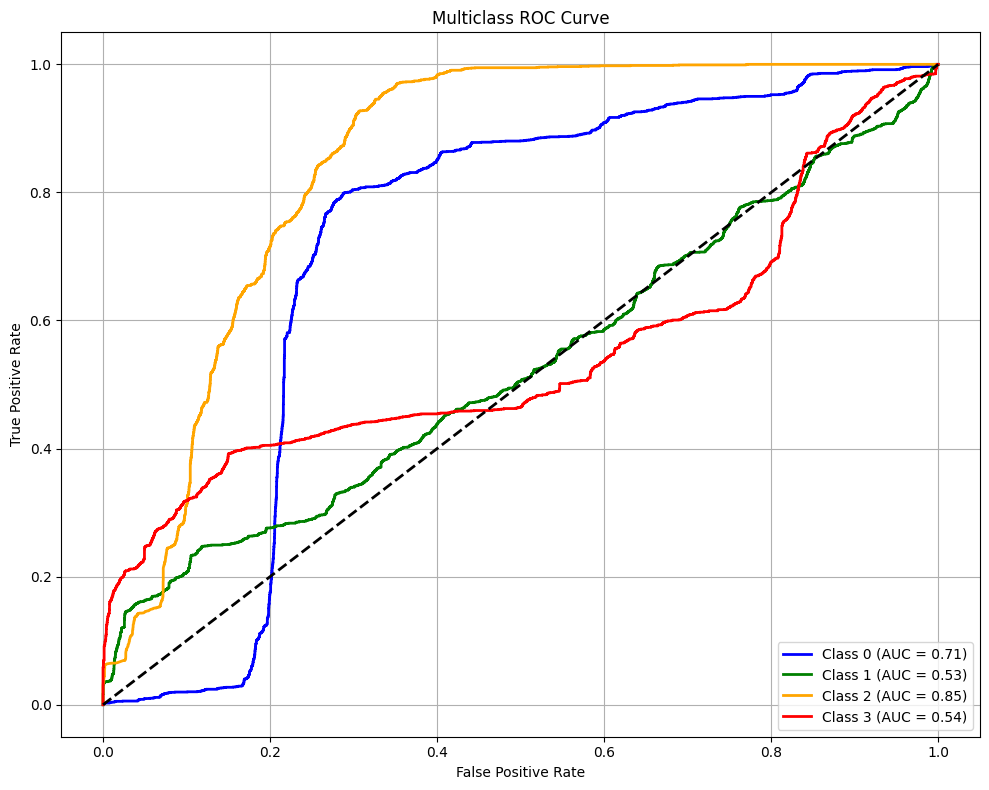

NameError: name 'precision_recall_fscore_support' is not defined

In [8]:
# Get predicted class labels
y_pred_probs = gru_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Calculate Metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print("\nTest Performance Metrics:")
print(f"Accuracy  : {test_accuracy:.4f}")
print(f"Precision : {test_precision:.4f}")
print(f"Recall    : {test_recall:.4f}")
print(f"F1 Score  : {test_f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ROC Curve and AUC
# Binarize the output labels for multiclass ROC
n_classes = y_test_categorical.shape[1]
y_test_bin = y_test_categorical
y_score = y_pred_probs

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

precision_vals, recall_vals, f1_vals, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1, 2, 3])

labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision_vals, width, label='Precision')
plt.bar(x, recall_vals, width, label='Recall')
plt.bar(x + width, f1_vals, width, label='F1 Score')

plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1 Score')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()